In [37]:
import pandas as pd
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt

In [63]:
from pathlib import Path


In [214]:
train_dir = "train_v2"

In [215]:
# Prepare function for fast image reading
def get_img(imgid):
    path = Path(train_dir) / '{}'.format(imgid)
    return PIL.Image.open(path)

In [216]:
# check how many images
train = os.listdir(train_dir)
print(f"Train files: {len(train)}. ---> {train[:3]}")

Train files: 192556. ---> ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg']


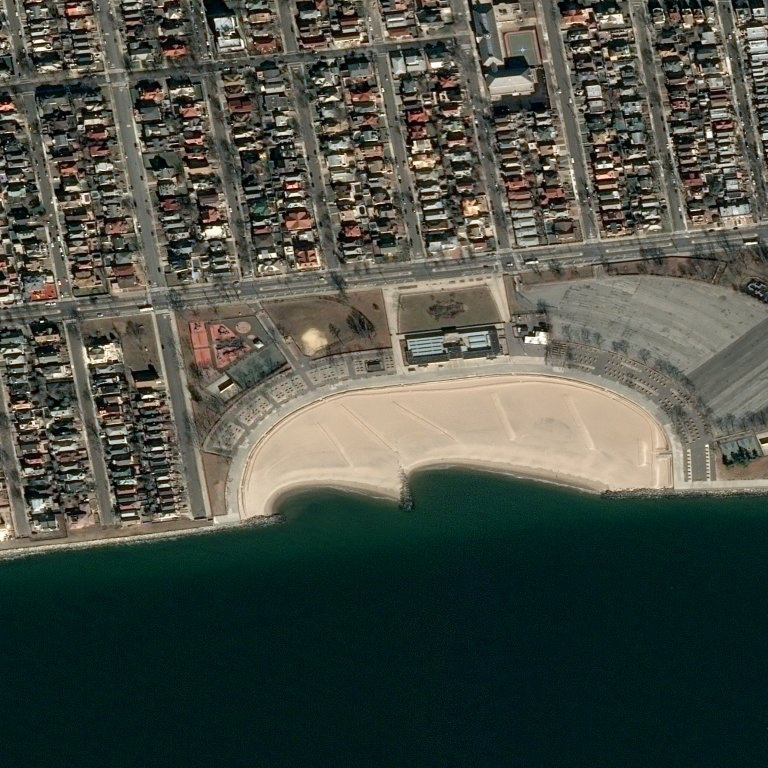

In [217]:
get_img("000c34352.jpg")

In [82]:
get_img("000c34352.jpg").size

(768, 768)

(768, 768) is quite big for visualization as well for the training on local machine

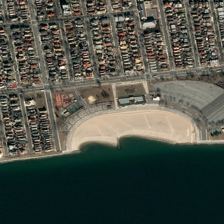

In [218]:
get_img("000c34352.jpg").resize((224, 224))

train_ship_segmentations_v2.csv is the main file in this task, it contain image path col:(ImageId) and target mask for segmentation col:(EncodedPixels)

In [219]:
df = pd.read_csv(f"train_ship_segmentations_v2.csv")
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Lets check some images with ships

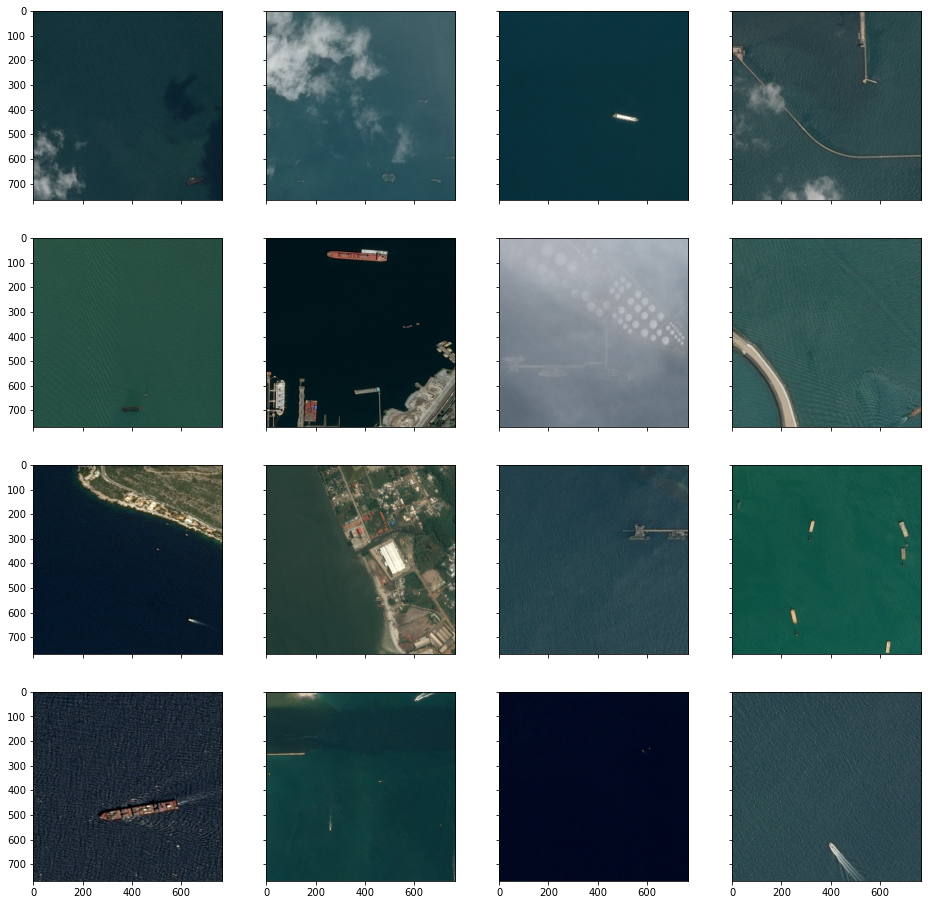

In [220]:
sample = df[~df.EncodedPixels.isna()].sample(16)

fig, ax = plt.subplots(4,4, sharex='col', sharey='row')
fig.set_size_inches(16, 16)

for i, imgid in enumerate(sample.ImageId):
    col = i % 4
    row = i // 4

    img = get_img(imgid)
    
    ax[row, col].imshow(img)

Same, withot ships

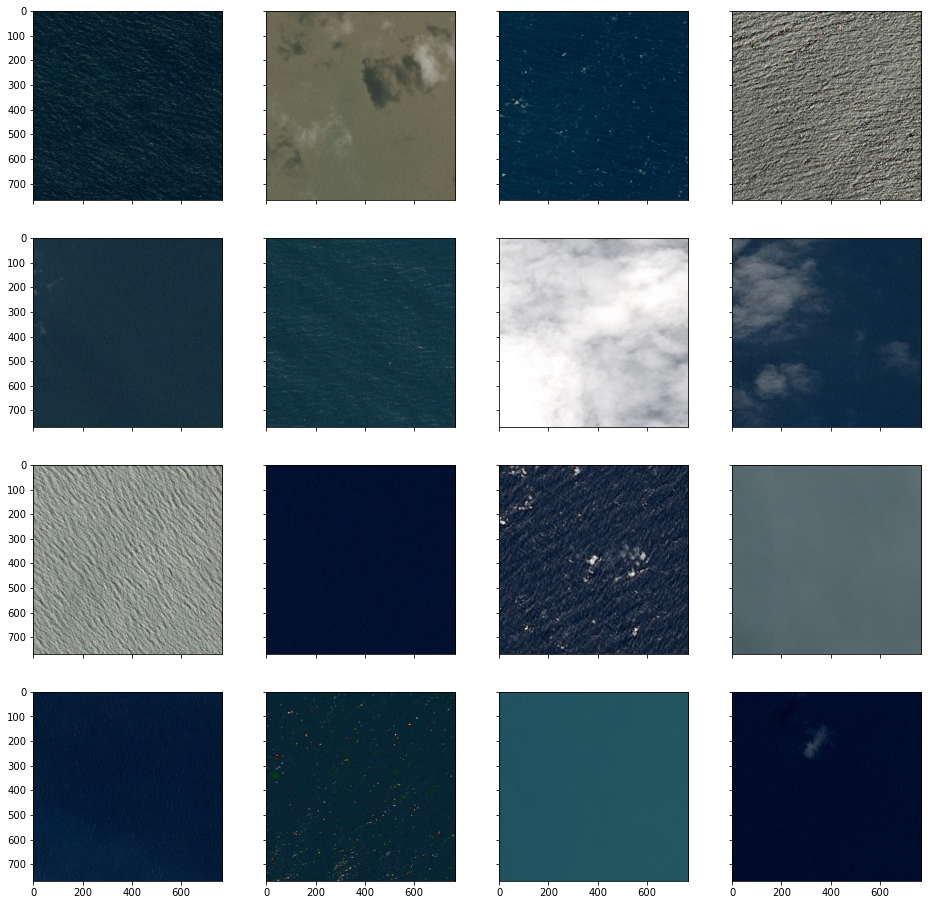

In [85]:
sample = df[df.EncodedPixels.isna()].sample(16)

fig, ax = plt.subplots(4,4, sharex='col', sharey='row')
fig.set_size_inches(16, 16)

for i, imgid in enumerate(sample.ImageId):
    col = i % 4
    row = i // 4
    
    img = get_img(imgid)
    
    ax[row, col].imshow(img)

Images contains a lot of oceans/seas, some little part of ports and very little full ground. There are also some % of very cloudly or "corrupted" images.


Lets check data balance in terms of images with ships and without

In [221]:
df["is_ship"] = True
df.loc[df["EncodedPixels"].isnull(), "is_ship"] = False
df[["ImageId", "is_ship"]].drop_duplicates()["is_ship"].value_counts()

False    150000
True      42556
Name: is_ship, dtype: int64

In [222]:
df['HasShip'] = df['EncodedPixels'].notnull()
df_grouped = df.groupby("ImageId").agg({'HasShip': ['first', 'sum']}) # counts amount of ships per image, sets ImageId to index
df_grouped.columns = ['HasShip', 'TotalShips']

Images: 192556 
Ships:  81723
Images with ships:    0.22 (42556)
Images with no ships: 0.78 (150000)


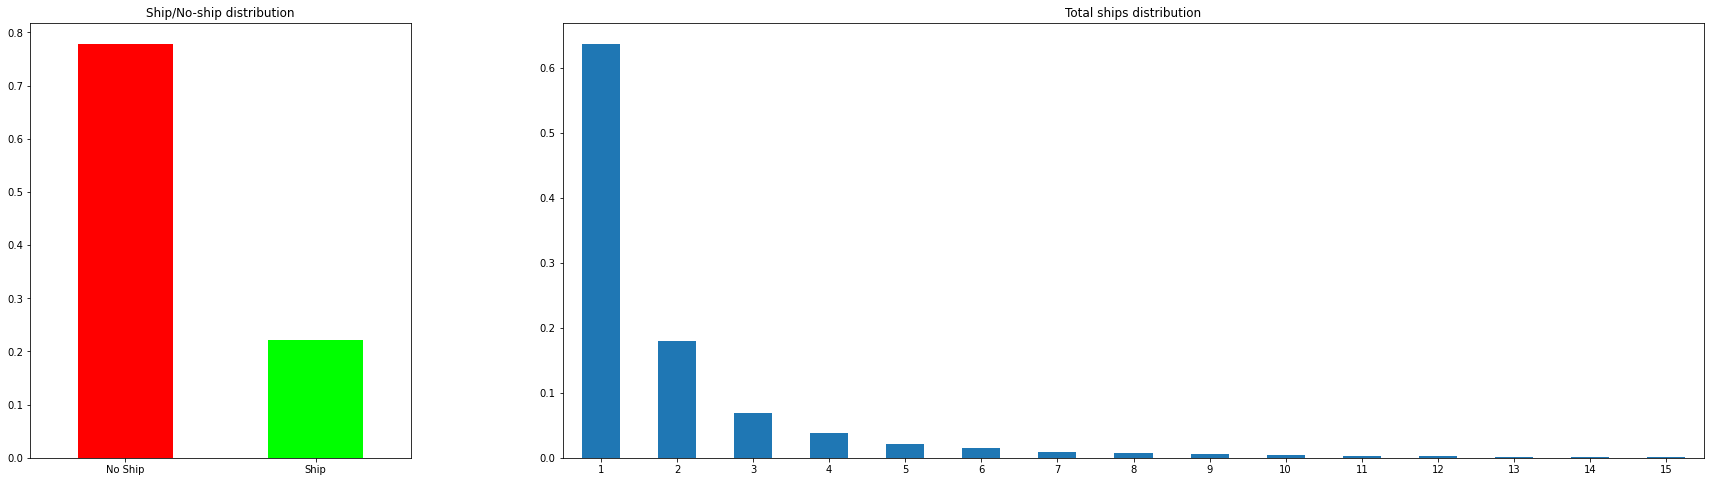

In [223]:
total = len(df_grouped)
ship = df_grouped['HasShip'].sum()
no_ship = total - ship
total_ships = int(df_grouped['TotalShips'].sum())

print(f"Images: {total} \nShips:  {total_ships}")
print(f"Images with ships:    {round(ship/total,2)} ({ship})")
print(f"Images with no ships: {round(no_ship/total,2)} ({no_ship})")

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 8), gridspec_kw = {'width_ratios':[1, 3]})

# Plot ship/no-ship with a bar plot
ship_ratio = df_grouped['HasShip'].value_counts() / total
ship_ratio = ship_ratio.rename(index={True: 'Ship', False: 'No Ship'})
ship_ratio.plot.bar(ax=axes[0], color=['red', 'lime'], rot=0, title="Ship/No-ship distribution");

# Plot TotalShips distribution with a bar plot
total_ships_distribution = df_grouped.loc[df_grouped['HasShip'], 'TotalShips'].value_counts().sort_index() / ship
total_ships_distribution.plot(kind='bar', ax=axes[1], rot=0, title="Total ships distribution");

1. Balance of images with ships not very bad, ~ 20% images has ships. ~40% of them have 2+ ships
2. While such balance is ok and could be easily handled in classification task, for segmentation, when we predict pixels, everything here is not so good.

Lets check ships' masks. Firstly we need to decode masks.

In [224]:
# This function transforms EncodedPixels into a list of pixels
# https://www.kaggle.com/julian3833/2-understanding-and-plotting-rle-bounding-boxes
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

0198728be.jpg


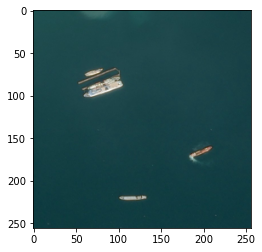

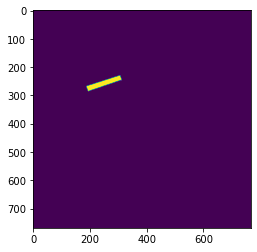

In [258]:
sample = df.loc[df["HasShip"]].sample(1)
img_id = sample.values[0][0]
print(img_id)
img_mask = sample.values[0][1]
plt.imshow(np.array(get_img(img_id).resize((256,256))))
plt.show()
plt.imshow(rle_decode(img_mask))
plt.show()

raw dataset splitted by certain ships mask, not images, so for full mask we need to group masks per image

In [260]:
group_df_ships = df.loc[df["is_ship"]][["ImageId","EncodedPixels"]].groupby("ImageId")[["EncodedPixels"]].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()

0198728be.jpg


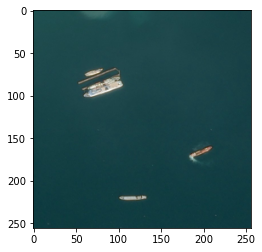

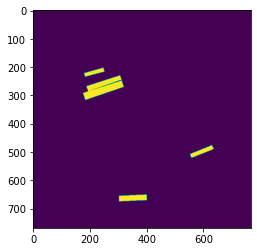

In [261]:
sample = group_df_ships.loc[group_df_ships["ImageId"]==img_id]
img_id = sample.values[0][0]
print(img_id)
img_mask = sample.values[0][1]
plt.imshow(np.array(get_img(img_id).resize((256,256))))
plt.show()
plt.imshow(rle_decode(img_mask))
plt.show()

In [272]:
masks_pixel_count = group_df_ships["EncodedPixels"].apply(lambda x: np.sum(rle_decode(x)))

In [285]:
print(masks_pixel_count.mean(), masks_pixel_count.std())

3009.9836215809755 4317.305720257303


<AxesSubplot:>

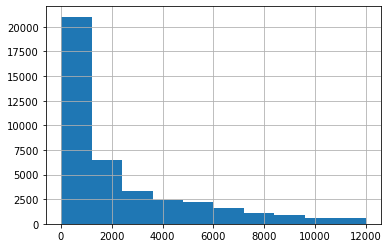

In [286]:
masks_pixel_count[masks_pixel_count< 12000].hist()

In [288]:
masks_pixel_part_of_img = masks_pixel_count / 768 / 768
print(masks_pixel_part_of_img.mean(), masks_pixel_part_of_img.median(), masks_pixel_part_of_img.std())

0.005103189462587063 0.002105712890625 0.007319650811525685


So, less than 1% of all pixels are related to the ships for images with ships. For whole dataset it is about less than 0.1%.
This is very heavy imbalance of classes. Probably for the trainig we need heavily undersample no-ships images. 
However, it still should be presented so model wont overfit always predict ships

Analysis of pixels for

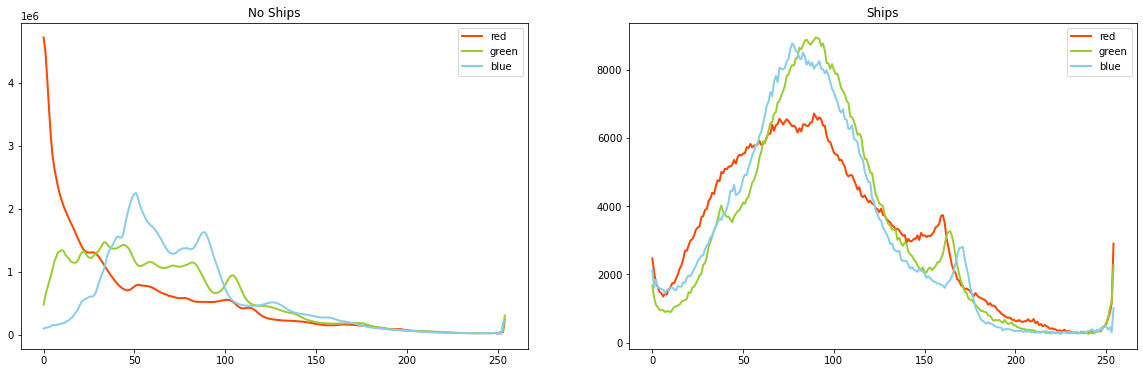

In [91]:
def apply_masks_to_img(img, _id, df):
    '''Apply masks to image given img, its id and the dataframe.'''
    masks = df[df.ImageId == _id].EncodedPixels.apply(lambda x: rle_decode(x)).tolist()
    masks = sum(masks)
    return img * masks.reshape(img.size[0], img.size[1], 1)


fig, ax = plt.subplots(1, 2, sharex='col')#, sharey='row')
fig.set_size_inches(20, 6)

mask = df.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = df[msk].ImageId.sample(250)
    imgs = [get_img(_id) for _id in _ids]
    
    # if we have an encoding to decode
    if i == 1:
        imgs = [apply_masks_to_img(i, _id, df) for (i, _id) in zip(imgs, _ids)]

    imgs = np.array(imgs)
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    # skip bincount index 0 to avoid the masked pixels to overpower the others.
    ax[i].plot(np.bincount(red.ravel())[1:], color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel())[1:], color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel())[1:], color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)